# import

In [ ]:
import os
import gc
import warnings
from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
)
from sklearn.impute import KNNImputer
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


In [ ]:
data = pd.read_csv('SPH6004/assignment1/data/sph6004_assignment1_data.csv')

In [182]:
data.shape

(50920, 165)

# EDA

In [31]:
data.shape

(50920, 165)

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50920 entries, 0 to 50919
Columns: 165 entries, id to weight_admit
dtypes: float64(160), int64(3), object(2)
memory usage: 64.1+ MB
None


In [ ]:
print(data.describe())

                 id  hospital_mortality     aki_stage  admission_age  \
count  5.092000e+04        50920.000000  50920.000000   50920.000000   
mean   3.498391e+07            0.102298      1.300393      64.942008   
std    2.893873e+06            0.303042      1.088128      17.278264   
min    3.000015e+07            0.000000      0.000000      18.002527   
25%    3.246663e+07            0.000000      0.000000      54.503884   
50%    3.498649e+07            0.000000      1.000000      66.713334   
75%    3.748413e+07            0.000000      2.000000      78.151289   
max    3.999981e+07            1.000000      3.000000     102.865603   

       heart_rate_min  heart_rate_max  heart_rate_mean       sbp_min  \
count    50841.000000    50841.000000     50841.000000  50823.000000   
mean        69.902996      102.494951        84.266427     93.250232   
std         15.141810       20.481365        15.726366     17.550959   
min          1.000000       36.000000        28.500000      0.1

In [ ]:
missing_values = data.isnull().sum()
missing_ratio = (data.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({'missing_values_count': missing_values, 'missing_ratio(%)': missing_ratio})
missing_df = missing_df[missing_df['missing_values_count'] > 0].sort_values(by='missing_values_count', ascending=False)

print(missing_df)

                 missing_values_count  missing_ratio(%)
thrombin_min                    50829             99.82
thrombin_max                    50829             99.82
d_dimer_max                     50811             99.79
d_dimer_min                     50811             99.79
ggt_max                         50448             99.07
...                               ...               ...
dbp_max                            97              0.19
dbp_mean                           97              0.19
heart_rate_mean                    79              0.16
heart_rate_max                     79              0.16
heart_rate_min                     79              0.16

[159 rows x 2 columns]


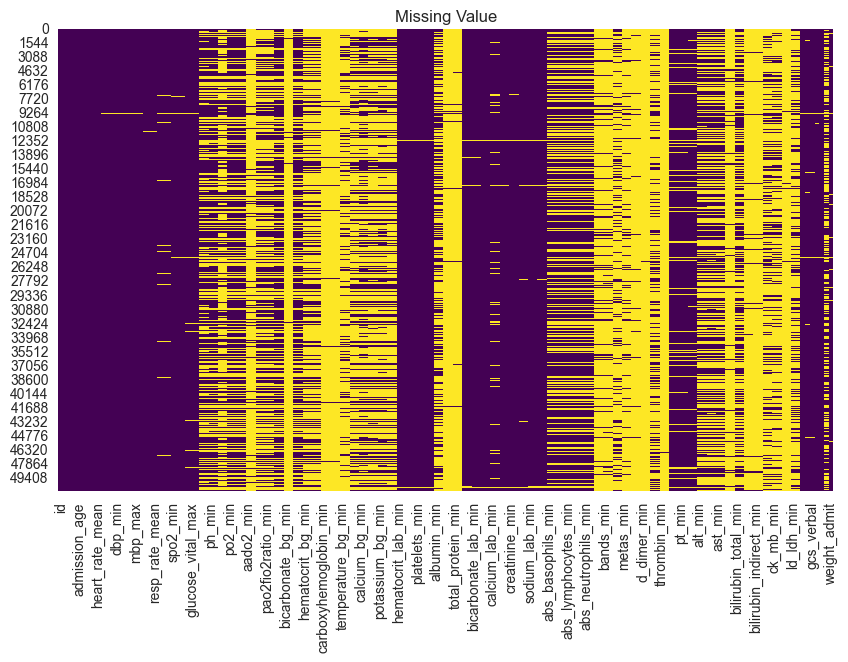

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Value")
plt.show()


In [ ]:
print(data['aki_stage'].value_counts())

aki_stage
0    16860
2    16288
1     9838
3     7934
Name: count, dtype: int64


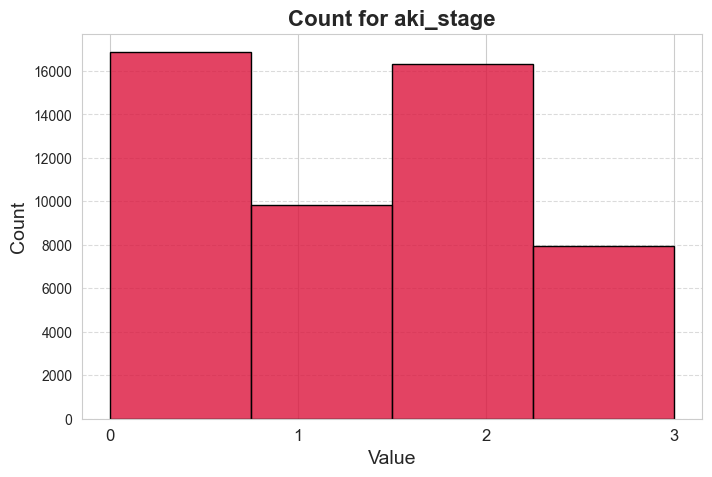

In [35]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(data['aki_stage'], bins=4, color="crimson", edgecolor="black", alpha=0.8)
plt.xticks(range(0, 4, 1), fontsize=12)
plt.title("Count for aki_stage", fontsize=16, fontweight='bold')
plt.xlabel("Value", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

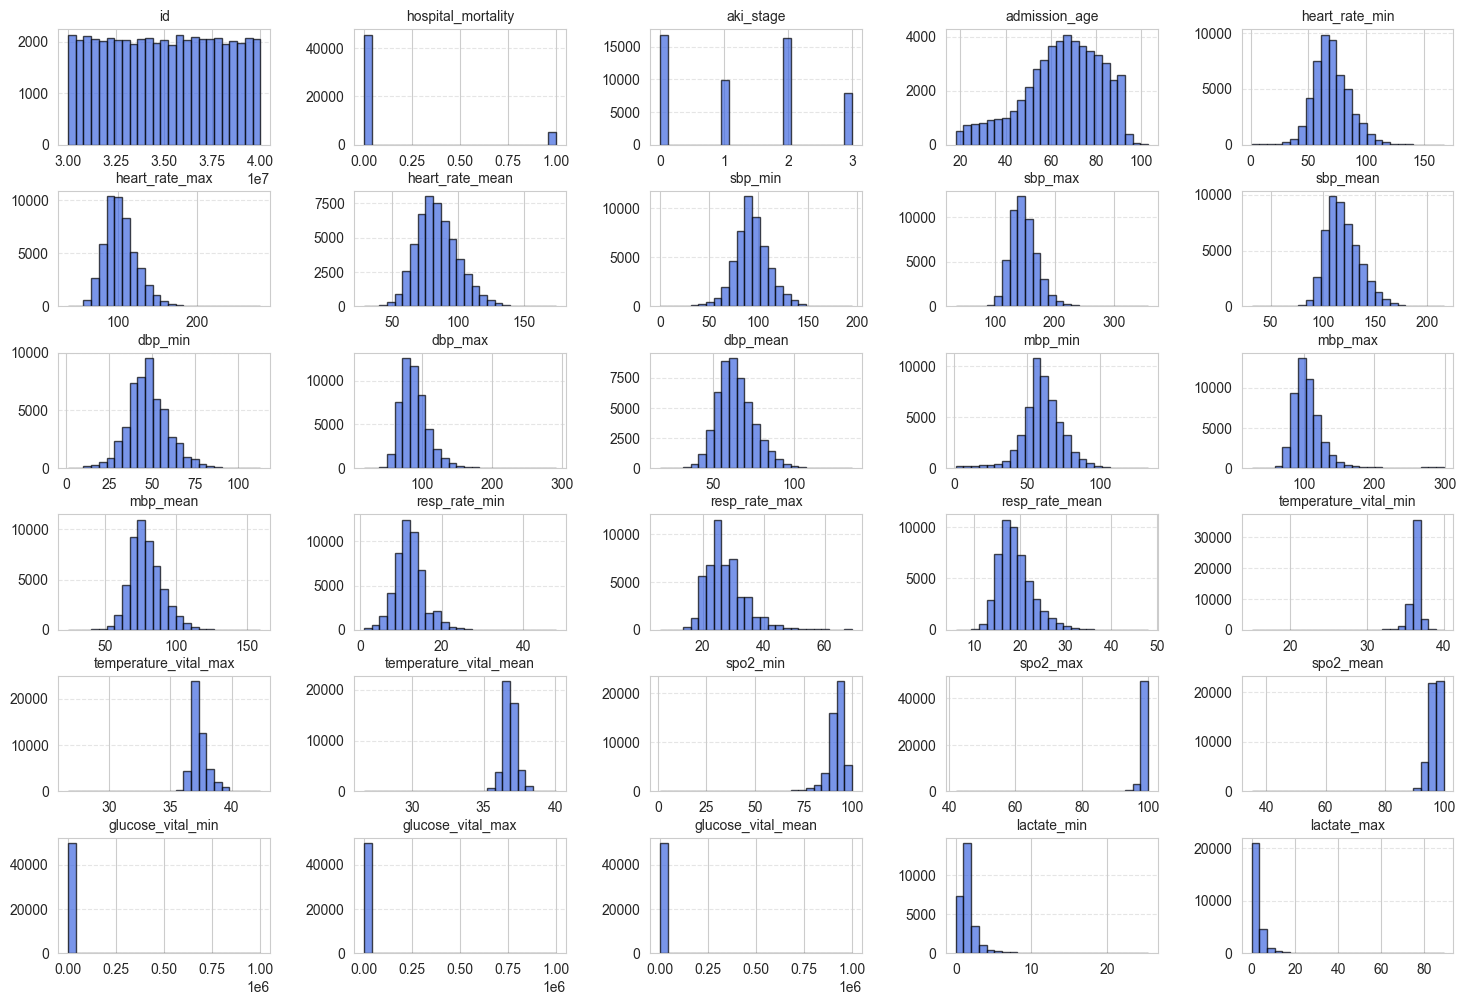

In [ ]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
selected_cols = num_cols[:30] 

fig = data[selected_cols].hist(figsize=(18, 12), bins=25, color="royalblue", edgecolor="black", alpha=0.7)

for ax in fig.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)  
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  
    ax.set_title(ax.get_title(), fontsize=10)  
    ax.grid(axis='y', linestyle='--', alpha=0.5)  

plt.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()

In [ ]:
num_data = data.select_dtypes(include=['int64', 'float64'])

corr_matrix = num_data.corr()

print(corr_matrix)

                          id  hospital_mortality  aki_stage  admission_age  \
id                  1.000000            0.003779  -0.003750       0.003382   
hospital_mortality  0.003779            1.000000   0.193220       0.128284   
aki_stage          -0.003750            0.193220   1.000000       0.172612   
admission_age       0.003382            0.128284   0.172612       1.000000   
heart_rate_min      0.003310            0.053756   0.057874      -0.169507   
...                      ...                 ...        ...            ...   
gcs_verbal         -0.002949           -0.222326  -0.202536      -0.025967   
gcs_eyes           -0.001326           -0.229848  -0.163209      -0.018938   
gcs_unable          0.004449            0.155545   0.155630      -0.033182   
height             -0.004563           -0.051524   0.013048      -0.181943   
weight_admit       -0.000010           -0.034612   0.135205      -0.113736   

                    heart_rate_min  heart_rate_max  heart_rate_

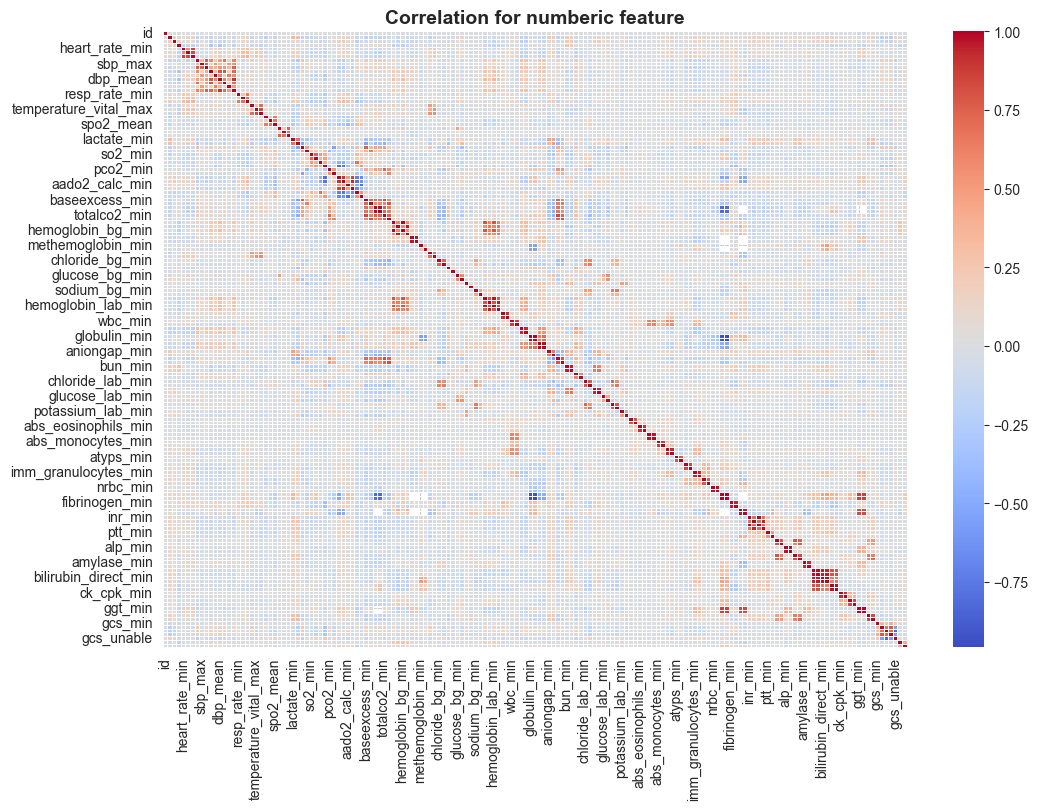

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,cmap='coolwarm', linewidths=0.5)

plt.title("Correlation for numberic feature", fontsize=14, fontweight='bold')
plt.show()


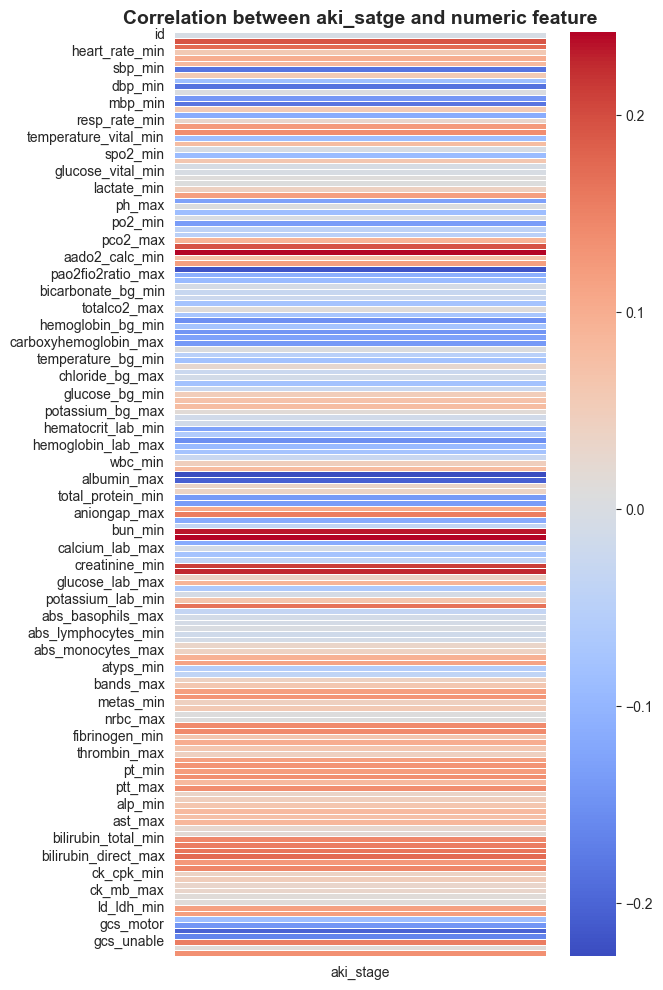

In [37]:
corr_with_aki = num_data.corr()['aki_stage'].drop('aki_stage') 

corr_df = corr_with_aki.to_frame()
plt.figure(figsize=(6, 12))  
sns.heatmap(corr_df, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

plt.title("Correlation between aki_satge and numeric feature", fontsize=14, fontweight='bold')

plt.show()


In [29]:
corr_with_aki.nlargest(10)

aado2_max               0.241974
bun_max                 0.241456
bun_min                 0.233869
creatinine_max          0.225514
creatinine_min          0.211392
aado2_min               0.195278
hospital_mortality      0.193220
bilirubin_direct_max    0.173581
admission_age           0.172612
potassium_lab_max       0.166625
Name: aki_stage, dtype: float64

In [30]:
corr_with_aki.nsmallest(20)

albumin_min             -0.227056
pao2fio2ratio_min       -0.219195
albumin_max             -0.205648
gcs_verbal              -0.202536
dbp_min                 -0.185314
sbp_min                 -0.184698
mbp_min                 -0.182459
gcs_eyes                -0.163209
hemoglobin_lab_min      -0.152002
hematocrit_bg_max       -0.151383
hemoglobin_bg_max       -0.144849
gcs_motor               -0.143177
dbp_mean                -0.142056
carboxyhemoglobin_max   -0.139063
total_protein_min       -0.138993
po2_min                 -0.135999
total_protein_max       -0.135499
ph_min                  -0.129083
carboxyhemoglobin_min   -0.128802
hematocrit_lab_min      -0.127172
Name: aki_stage, dtype: float64

# aki_satge

## prepare

In [183]:
missing_percentage = data[['gender', 'race']].isnull().mean() * 100
print(missing_percentage)

gender   0.00
race     0.00
dtype: float64


In [184]:
missing_rate = data.isnull().sum() / len(data) * 100
correlation = data.select_dtypes(include=['number']).corr()['aki_stage'].abs().sort_values(ascending=False)

In [193]:
columns_to_drop = missing_rate[(missing_rate > 50) & (correlation < 0.7)].index
# columns_to_drop = missing_rate[(missing_rate > 50)].index
data_cleaned = data.drop(columns=columns_to_drop)

In [194]:
data_cleaned.shape

(50920, 90)

In [195]:
X = data_cleaned.drop(columns=['aki_stage']) 
y = data_cleaned['aki_stage']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

numeric_cols = X_train.select_dtypes(include=['number']).columns
X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].mean())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_train[numeric_cols].mean())  

for col in categorical_cols:
    mode_value = X_train[col].mode()[0]  
    X_train[col] = X_train[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_cat = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

X_train_cat.columns = encoder.get_feature_names_out(categorical_cols)
X_test_cat.columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns=numeric_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns=numeric_cols)

X_train_processed = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_num, X_test_cat], axis=1)

print("train_shape:", X_train_processed.shape, "test_shape:", X_test_processed.shape)

train_shape: (40736, 120) test_shape: (10184, 120)


In [188]:
print("X_train null？", X_train_processed.isnull().values.any())
print("X_test null？", X_test_processed.isnull().values.any())

X_train null？ False
X_test null？ False


In [196]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[0.1, 0.01, 0.001, 0.0001], cv=5, max_iter=5000, random_state=42)
lasso_cv.fit(X_train_processed, y_train)

print(f"Best alpha: {lasso_cv.alpha_}")

lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=5000, tol=1e-5)
lasso.fit(X_train_processed, y_train)

selected_features = X_train_processed.columns[lasso.coef_ != 0].tolist()

print("count for features:", len(selected_features))
print("selected features:", selected_features)

Best alpha: 0.0001
count for features: 85
selected features: ['id', 'hospital_mortality', 'admission_age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_vital_min', 'temperature_vital_max', 'temperature_vital_mean', 'spo2_max', 'spo2_mean', 'lactate_min', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'hematocrit_lab_min', 'hematocrit_lab_max', 'hemoglobin_lab_min', 'hemoglobin_lab_max', 'platelets_min', 'platelets_max', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_lab_min', 'bicarbonate_lab_max', 'bun_min', 'bun_max', 'calcium_lab_min', 'calcium_lab_max', 'chloride_lab_min', 'chloride_lab_max', 'creatinine_max', 'glucose_lab_max', 'sodium_lab_min', 'potassium_lab_min', 'potassium_lab_max', 'abs_lymphocytes_min', 'abs_neutrophils_max', 'inr_max', 'pt_min', 'pt_max', 'ptt_min', 'ptt_m

In [197]:
alpha = 0.01  
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(X_train_processed, y_train)

selected_features = X_train_processed.columns[lasso.coef_ != 0].tolist()

print("count for features:", len(selected_features))
print("selected features:", selected_features)


count for features: 10
selected features: ['hospital_mortality', 'admission_age', 'dbp_min', 'mbp_min', 'resp_rate_max', 'hemoglobin_lab_min', 'bun_max', 'ptt_max', 'gcs_verbal', 'gender_M']


In [190]:
X_train_selected = X_train_processed[selected_features]
X_test_selected = X_test_processed[selected_features]

print("selected train:", X_train_selected.shape)
print("selected test:", X_test_selected.shape)

display(X_train_selected.head())


selected train: (40736, 10)
selected test: (10184, 10)


,hospital_mortality,admission_age,dbp_min,mbp_min,resp_rate_max,hemoglobin_lab_min,bun_max,ptt_max,gcs_verbal,gender_M
0,0.00,0.74,0.29,0.27,0.25,0.49,0.10,1.00,0.00,0.00
1,0.00,0.29,0.50,0.49,0.51,0.29,0.03,0.27,0.80,0.00
2,0.00,0.49,0.45,0.44,0.43,0.43,0.07,0.17,0.20,1.00
3,0.00,0.67,0.44,0.43,0.38,0.38,0.05,0.18,0.80,0.00
4,0.00,0.53,0.60,0.59,0.37,0.77,0.07,0.19,0.00,1.00


## model

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import (
    GradientBoostingRegressor, GradientBoostingClassifier,
    AdaBoostRegressor, AdaBoostClassifier,
    RandomForestRegressor, RandomForestClassifier
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, roc_auc_score,
    mean_squared_error, r2_score
)

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)


class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, task_type="classification"):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.task_type = task_type
        self.results = []

        # self.scaler = StandardScaler()
        # self.X_train = self.scaler.fit_transform(self.X_train)
        # self.X_test = self.scaler.transform(self.X_test)

        self.models = self.get_models()

    def get_models(self):
        if self.task_type == "classification":
            return {
                "Logistic Regression": LogisticRegression(max_iter=500),
                "SVM (Linear Kernel)": SVC(kernel="linear", probability=True),
                "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
                "Decision Tree": DecisionTreeClassifier(),
                "Random Forest": RandomForestClassifier(n_estimators=100),
                "GBDT": GradientBoostingClassifier(n_estimators=100),
                "AdaBoost": AdaBoostClassifier(n_estimators=100)
            }
        else: 
            return {
                "Linear Regression": LinearRegression(),
                "SVM (Linear Kernel)": SVR(kernel="linear"),
                "SVM (RBF Kernel)": SVR(kernel="rbf"),
                "Decision Tree": DecisionTreeRegressor(),
                "Random Forest": RandomForestRegressor(n_estimators=100),
                "GBDT": GradientBoostingRegressor(n_estimators=100),
                "AdaBoost": AdaBoostRegressor(n_estimators=100)
            }

    def evaluate_model(self, model, model_name):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)

        if self.task_type == "classification":
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average="weighted")
            recall = recall_score(self.y_test, y_pred, average="weighted")
            
            auc = None
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(self.X_test)
                if self.y_train.nunique() == 2: 
                    auc = roc_auc_score(self.y_test, y_pred_proba[:, 1])
                else:  
                    lb = LabelBinarizer()
                    y_test_binarized = lb.fit_transform(self.y_test)
                    auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

            self.results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "F1 Score": f1,
                "Recall": recall,
                "AUC": auc
            })

        else: 
            mse = mean_squared_error(self.y_test, y_pred)
            rmse = np.sqrt(mse)  
            r2 = r2_score(self.y_test, y_pred)
            
            n, p = self.X_test.shape
            adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

            self.results.append({
                "Model": model_name,
                "MSE": mse,
                "RMSE": rmse,
                "R² Score": r2,
                "Adjusted R²": adj_r2
            })

    def run(self):
        for model_name, model in self.models.items():
            print(f"Training process: {model_name} ...")
            self.evaluate_model(model, model_name)

        results_df = pd.DataFrame(self.results)

        if self.task_type == "classification":
            results_df = results_df.sort_values(by="AUC", ascending=False)
        else:
            results_df = results_df.sort_values(by="Adjusted R²", ascending=False)

        print("\nresult for model：")
        print(results_df)

        return results_df


In [192]:
# all data
if __name__ == "__main__":
    # X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.9, random_state=42)
    # X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    # print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    # print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = ModelEvaluator(X_train_selected, X_test_selected, y_train, y_test, task_type="classification")
    results_df = evaluator.run()

Training process: Logistic Regression ...
Training process: SVM (Linear Kernel) ...
Training process: SVM (RBF Kernel) ...
Training process: Decision Tree ...
Training process: Random Forest ...
Training process: GBDT ...
Training process: AdaBoost ...

result for model：
                 Model  Accuracy  F1 Score  Recall  AUC
5                 GBDT      0.46      0.41    0.46 0.67
0  Logistic Regression      0.44      0.39    0.44 0.66
2     SVM (RBF Kernel)      0.44      0.39    0.44 0.66
4        Random Forest      0.44      0.41    0.44 0.66
6             AdaBoost      0.45      0.40    0.45 0.65
1  SVM (Linear Kernel)      0.43      0.38    0.43 0.65
3        Decision Tree      0.34      0.34    0.34 0.55


In [ ]:
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, task_type="classification"):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.use_cv = use_cv  
        self.cv_folds = cv_folds  
        self.task_type = task_type
        self.results = []

        self.models = self.get_models()

    def get_models(self):
        return {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "SVM (Linear Kernel)": SVC(kernel="linear", probability=True),
            "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "GBDT (sklearn)": GradientBoostingClassifier(n_estimators=100),
            "AdaBoost": AdaBoostClassifier(n_estimators=100)
            # "LightGBM": lgb.LGBMClassifier(n_estimators=100, verbosity=-1),
            # "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
            # "CatBoost": cb.CatBoostClassifier(verbose=0)
        }

    def evaluate_model(self, model, model_name):

        lb = LabelBinarizer()
        lb.fit(self.y_train)  
        y_train_binarized = lb.transform(self.y_train)
        
        if self.use_cv:
            print(f"Using {self.cv_folds}-fold cross-validation for {model_name} ...")
            skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)

            accuracy_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy")
            f1_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="f1_weighted")
            recall_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="recall_weighted")

            auc_scores = []
            for train_idx, val_idx in skf.split(self.X_train, self.y_train):
                X_train_fold, X_val_fold = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                y_train_fold, y_val_fold = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                model.fit(X_train_fold, y_train_fold)
                if hasattr(model, "predict_proba"):
                    y_pred_proba = model.predict_proba(X_val_fold)

                    y_val_binarized = lb.transform(y_val_fold)

                    auc_scores.append(roc_auc_score(y_val_binarized, y_pred_proba, multi_class="ovr"))

            self.results.append({
                "Model": model_name,
                "Accuracy": np.mean(accuracy_scores),
                "F1 Score": np.mean(f1_scores),
                "Recall": np.mean(recall_scores),
                "AUC": np.mean(auc_scores) if auc_scores else None
            })
        
        else:
            print(f"Training {model_name} without cross-validation ...")
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)

            y_pred_proba = model.predict_proba(self.X_test) if hasattr(model, "predict_proba") else None

            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average="weighted")
            recall = recall_score(self.y_test, y_pred, average="weighted")

            auc = None
            if y_pred_proba is not None:
                y_test_binarized = lb.transform(self.y_test)  
                auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

            self.results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "F1 Score": f1,
                "Recall": recall,
                "AUC": auc
            })


    def run(self):
        for model_name, model in self.models.items():
            self.evaluate_model(model, model_name)

        results_df = pd.DataFrame(self.results)
        results_df = results_df.sort_values(by="AUC", ascending=False)

        print("\nModel evaluation results:")
        print(results_df)

        return results_df



class TwoStageModelEvaluator(ModelEvaluator):
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5):
        super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification")

        self.y_train_binary = (self.y_train != 0).astype(int)
        self.y_test_binary = (self.y_test != 0).astype(int)

        self.binary_model = None  
        self.multi_class_model = None  


    def select_best_binary_model(self):
        results_df = super().run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"The binary classification model with the highest AUC: {best_model_name}")
        self.binary_model = self.models[best_model_name]

    def train_binary_model(self):
        if self.binary_model is None:
            print("Please runing  select_best_binary_model()")
            return
        
        print("Training the best model for this stage ...")
        self.binary_model.fit(self.X_train, self.y_train_binary)
        self.y_pred_binary = self.binary_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
        print(f"Accuracy for binary stage: {accuracy:.4f}")

    def select_best_multi_class_model(self):
        yes_indices = np.where(self.y_pred_binary == 1)[0]

        if len(yes_indices) == 0:
            print("No yes feature error")
            return

        selected_indices = np.where(self.y_train_binary == 1)[0]
        X_train_yes = self.X_train.iloc[selected_indices]  
        y_train_yes = self.y_train.iloc[selected_indices]

        X_test_yes = self.X_test.iloc[yes_indices]
        y_test_yes = self.y_test.iloc[yes_indices]

        multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, task_type="classification")
        results_df = multi_class_evaluator.run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"The multi-classification model with the highest F1: {best_model_name}")
        self.multi_class_model = self.models[best_model_name]

    def train_multi_class_model(self):
        if self.multi_class_model is None:
            print("Please running select_best_multi_class_model()")
            return

        self.multi_class_model.fit(self.X_train, self.y_train)
        y_pred = self.multi_class_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy for multi-classfication stage: {accuracy:.4f}")

    def run(self):
        self.train_binary_model()
        self.train_multi_class_model()

In [ ]:
# test for small data
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.9, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small,use_cv=True, cv_folds=5)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  


X_train_small.shape: (2036, 37), y_train_small.shape: (2036,)
X_test_small.shape: (509, 37), y_test_small.shape: (509,)
Using 5-fold cross-validation for Logistic Regression ...
Using 5-fold cross-validation for SVM (Linear Kernel) ...
Using 5-fold cross-validation for SVM (RBF Kernel) ...
Using 5-fold cross-validation for Decision Tree ...
Using 5-fold cross-validation for Random Forest ...
Using 5-fold cross-validation for GBDT (sklearn) ...
Using 5-fold cross-validation for AdaBoost ...

Model evaluation results:
                 Model  Accuracy  F1 Score  Recall  AUC
0  Logistic Regression      0.47      0.43    0.47 0.68
4        Random Forest      0.49      0.44    0.48 0.68
2     SVM (RBF Kernel)      0.47      0.43    0.47 0.68
1  SVM (Linear Kernel)      0.47      0.42    0.47 0.68
5       GBDT (sklearn)      0.48      0.44    0.47 0.67
6             AdaBoost      0.44      0.42    0.44 0.63
3        Decision Tree      0.34      0.34    0.35 0.55
The binary classification mode

In [110]:
# test for small data without cv
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.9, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (4073, 37), y_train_small.shape: (4073,)
X_test_small.shape: (1018, 37), y_test_small.shape: (1018,)
Training Logistic Regression without cross-validation ...
Training SVM (Linear Kernel) without cross-validation ...
Training SVM (RBF Kernel) without cross-validation ...
Training Decision Tree without cross-validation ...
Training Random Forest without cross-validation ...
Training GBDT (sklearn) without cross-validation ...
Training AdaBoost without cross-validation ...

Model evaluation results:
                 Model  Accuracy  F1 Score  Recall  AUC
0  Logistic Regression      0.47      0.43    0.47 0.70
5       GBDT (sklearn)      0.47      0.43    0.47 0.70
4        Random Forest      0.47      0.43    0.47 0.70
1  SVM (Linear Kernel)      0.47      0.42    0.47 0.69
2     SVM (RBF Kernel)      0.46      0.41    0.46 0.69
6             AdaBoost      0.44      0.41    0.44 0.65
3        Decision Tree      0.33      0.34    0.33 0.54
The binary classification mo

In [199]:
# all data without cv
if __name__ == "__main__":
    evaluator = TwoStageModelEvaluator(X_train_selected, X_test_selected, y_train, y_test)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

Training Logistic Regression without cross-validation ...
Training SVM (Linear Kernel) without cross-validation ...
Training SVM (RBF Kernel) without cross-validation ...
Training Decision Tree without cross-validation ...
Training Random Forest without cross-validation ...
Training GBDT (sklearn) without cross-validation ...
Training AdaBoost without cross-validation ...

Model evaluation results:
                 Model  Accuracy  F1 Score  Recall  AUC
5       GBDT (sklearn)      0.46      0.41    0.46 0.67
0  Logistic Regression      0.44      0.39    0.44 0.66
2     SVM (RBF Kernel)      0.44      0.39    0.44 0.66
4        Random Forest      0.44      0.41    0.44 0.65
6             AdaBoost      0.45      0.40    0.45 0.65
1  SVM (Linear Kernel)      0.43      0.38    0.43 0.65
3        Decision Tree      0.34      0.34    0.34 0.55
The binary classification model with the highest AUC: GBDT (sklearn)
Training the best model for this stage ...
Accuracy for binary stage: 0.7189
Trai

In [200]:
# all data with cv
if __name__ == "__main__":
    evaluator = TwoStageModelEvaluator(X_train_selected, X_test_selected, y_train, y_test,use_cv=True, cv_folds=5)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model() 

Using 5-fold cross-validation for Logistic Regression ...
Using 5-fold cross-validation for SVM (Linear Kernel) ...
Using 5-fold cross-validation for SVM (RBF Kernel) ...
Using 5-fold cross-validation for Decision Tree ...
Using 5-fold cross-validation for Random Forest ...
Using 5-fold cross-validation for GBDT (sklearn) ...
Using 5-fold cross-validation for AdaBoost ...

Model evaluation results:
                 Model  Accuracy  F1 Score  Recall  AUC
5       GBDT (sklearn)      0.45      0.40    0.45 0.67
0  Logistic Regression      0.44      0.39    0.44 0.66
2     SVM (RBF Kernel)      0.44      0.39    0.44 0.66
6             AdaBoost      0.45      0.40    0.45 0.66
4        Random Forest      0.43      0.40    0.43 0.65
1  SVM (Linear Kernel)      0.43      0.38    0.43 0.65
3        Decision Tree      0.34      0.34    0.34 0.54
The binary classification model with the highest AUC: GBDT (sklearn)
Training the best model for this stage ...
Accuracy for binary stage: 0.7188
Trai

In [ ]:
from tabpfn import TabPFNClassifier

clf = TabPFNClassifier()
clf.fit(X_train_small, y_train_small)

prediction_probabilities = clf.predict_proba(X_test_small)
print("ROC AUC:", roc_auc_score(y_test_small, prediction_probabilities, multi_class="ovr"))

predictions = clf.predict(X_test_small)
print("Accuracy", accuracy_score(y_test_small, predictions))

ROC AUC: 0.6632734897815759
Accuracy 0.4381139489194499


# More work

## smote

In [62]:
value_counts = data['aki_stage'].value_counts()
print(value_counts)

aki_stage
0    16860
2    16288
1     9838
3     7934
Name: count, dtype: int64


In [63]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_multi, y_train_multi = smote.fit_resample(X_train_selected, y_train)

print("SMOTE_distribution：")
print(pd.Series(y_train_multi).value_counts())


SMOTE_distribution：
aki_stage
3    13550
0    13550
2    13550
1    13550
Name: count, dtype: int64


In [ ]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_multi, y_train_multi, test_size=0.9, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model() 

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model() 

X_train_small.shape: (5420, 10), y_train_small.shape: (5420,)
X_test_small.shape: (1018, 10), y_test_small.shape: (1018,)
Training process: Logistic Regression ...
Training process: SVM (Linear Kernel) ...
Training process: SVM (RBF Kernel) ...
Training process: Decision Tree ...
Training process: Random Forest ...
Training process: GBDT ...
Training process: AdaBoost ...

result for model：
                 Model  Accuracy  F1 Score    Recall       AUC
0  Logistic Regression  0.418468  0.396705  0.418468  0.658033
1  SVM (Linear Kernel)  0.407662  0.384463  0.407662  0.654898
5                 GBDT  0.420432  0.411167  0.420432  0.653363
2     SVM (RBF Kernel)  0.418468  0.402007  0.418468  0.650772
4        Random Forest  0.398821  0.397381  0.398821  0.641140
6             AdaBoost  0.398821  0.392434  0.398821  0.637370
3        Decision Tree  0.330059  0.335943  0.330059  0.547350
The binary classification model with the highest AUC: Logistic Regression
Training the best model for 

## More engineering

In [201]:
X = data_cleaned.drop(columns=['aki_stage'])  
y = data_cleaned['aki_stage']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].mean())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_train[numeric_cols].mean())  

for col in categorical_cols:
    mode_value = X_train[col].mode()[0]  
    X_train[col] = X_train[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_cat = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

X_train_cat.columns = encoder.get_feature_names_out(categorical_cols)
X_test_cat.columns = encoder.get_feature_names_out(categorical_cols)

X_train_processed = pd.concat([X_train[numeric_cols], X_train_cat], axis=1)
X_test_processed = pd.concat([X_test[numeric_cols], X_test_cat], axis=1)

print("train_shape:", X_train_processed.shape, "test_shape:", X_test_processed.shape)


train_shape: (40736, 120) test_shape: (10184, 120)


In [202]:
import featuretools as ft

primitives_df = ft.primitives.list_primitives()
print(primitives_df)


                            name         type  \
0                          trend  aggregation   
1      num_true_since_last_false  aggregation   
2    is_monotonically_increasing  aggregation   
3      max_consecutive_negatives  aggregation   
4                       kurtosis  aggregation   
..                           ...          ...   
198           add_numeric_scalar    transform   
199                savgol_filter    transform   
200                       season    transform   
201                  square_root    transform   
202               modulo_numeric    transform   

                                           description  \
0          Calculates the trend of a column over time.   
1    Calculates the number of 'True' values since t...   
2    Determines if a series is monotonically increa...   
3    Determines the maximum number of consecutive n...   
4        Calculates the kurtosis for a list of numbers   
..                                                 ...   
198  

In [203]:
import featuretools as ft

es = ft.EntitySet(id="aki_prediction")

es = es.add_dataframe(
    dataframe_name="patients",
    dataframe=X_train_processed,
    index="index"
)


feature_matrix_train, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="patients",
    agg_primitives=["mean", "max", "min", "std", "count", "sum"],  
    trans_primitives=["percentile", "absolute"],  
    max_depth=1
)


X_train_final = feature_matrix_train.reset_index()
print("train data features:", X_train_final.shape[1])

es_test = ft.EntitySet(id="aki_prediction_test")

es_test = es_test.add_dataframe(
    dataframe_name="patients",
    dataframe=X_test_processed,
    index="index" 
)

feature_matrix_test = ft.calculate_feature_matrix(
    features=feature_defs,  
    entityset=es_test
)

X_test_final = feature_matrix_test.reset_index()
print("test data features:", X_test_final.shape[1])


train data features: 361
test data features: 361


In [204]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_final_scaled = pd.DataFrame(scaler.fit_transform(X_train_final), columns=X_train_final.columns)

X_test_final_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns)

print("train data:", X_train_final_scaled.shape)
print("test data:", X_test_final_scaled.shape)


train data: (40736, 361)
test data: (10184, 361)


In [78]:
print("X_train null？", X_train_final_scaled.isnull().values.any())
print("X_test null？", X_test_final_scaled.isnull().values.any())

X_train null？ False
X_test null？ False


In [79]:
alpha = 0.01  
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(X_train_final_scaled, y_train)

selected_features = X_train_final_scaled.columns[lasso.coef_ != 0].tolist()

print("count for features:", len(selected_features))
print("selected features:", selected_features)

count for features: 37
selected features: ['hospital_mortality', 'gcs_verbal', 'gender_M', 'ABSOLUTE(gcs_verbal)', 'ABSOLUTE(gender_M)', 'ABSOLUTE(hospital_mortality)', 'PERCENTILE(abs_lymphocytes_min)', 'PERCENTILE(admission_age)', 'PERCENTILE(aniongap_max)', 'PERCENTILE(bun_max)', 'PERCENTILE(bun_min)', 'PERCENTILE(calcium_lab_min)', 'PERCENTILE(chloride_lab_max)', 'PERCENTILE(chloride_lab_min)', 'PERCENTILE(creatinine_max)', 'PERCENTILE(dbp_min)', 'PERCENTILE(gcs_eyes)', 'PERCENTILE(gcs_verbal)', 'PERCENTILE(gender_M)', 'PERCENTILE(glucose_lab_max)', 'PERCENTILE(glucose_vital_min)', 'PERCENTILE(heart_rate_max)', 'PERCENTILE(hemoglobin_lab_min)', 'PERCENTILE(lactate_min)', 'PERCENTILE(mbp_max)', 'PERCENTILE(po2_min)', 'PERCENTILE(potassium_lab_max)', 'PERCENTILE(pt_max)', 'PERCENTILE(ptt_max)', 'PERCENTILE(resp_rate_max)', 'PERCENTILE(sbp_max)', 'PERCENTILE(sbp_min)', 'PERCENTILE(spo2_max)', 'PERCENTILE(spo2_min)', 'PERCENTILE(temperature_vital_max)', 'PERCENTILE(temperature_vital_mi

In [81]:
X_train_selected = X_train_final_scaled[selected_features]
X_test_selected = X_test_final_scaled[selected_features]

print("selected train:", X_train_selected.shape)
print("selected test:", X_test_selected.shape)

display(X_train_selected.head())

selected train: (40736, 37)
selected test: (10184, 37)


,hospital_mortality,gcs_verbal,gender_M,ABSOLUTE(gcs_verbal),ABSOLUTE(gender_M),ABSOLUTE(hospital_mortality),PERCENTILE(abs_lymphocytes_min),PERCENTILE(admission_age),PERCENTILE(aniongap_max),PERCENTILE(bun_max),...,PERCENTILE(pt_max),PERCENTILE(ptt_max),PERCENTILE(resp_rate_max),PERCENTILE(sbp_max),PERCENTILE(sbp_min),PERCENTILE(spo2_max),PERCENTILE(spo2_min),PERCENTILE(temperature_vital_max),PERCENTILE(temperature_vital_min),PERCENTILE(weight_admit)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.265748,0.799828,0.927581,0.682190,...,0.585979,1.000000,0.172880,0.331828,0.007880,1.000000,0.096888,0.211293,0.010065,0.266890
1,0.0,0.8,0.0,0.8,0.0,0.0,0.828925,0.117712,0.246901,0.045710,...,0.845679,0.869994,0.936968,0.079968,0.210261,0.173315,0.153763,0.938407,0.638002,0.174852
2,0.0,0.2,1.0,0.2,1.0,0.0,0.611270,0.342752,0.157224,0.529508,...,0.568428,0.662723,0.833454,0.474383,0.288671,1.000000,0.520765,0.775893,0.185884,0.616484
3,0.0,0.8,0.0,0.8,0.0,0.0,0.344660,0.689088,0.351982,0.269854,...,0.963474,0.684163,0.716499,0.557579,0.232245,1.000000,0.205111,0.311317,0.244519,0.281800
4,0.0,0.0,1.0,0.0,1.0,0.0,0.079847,0.424132,0.246901,0.454032,...,0.724457,0.755857,0.663447,0.889002,0.254720,1.000000,0.520765,0.547158,0.748545,0.764882


In [ ]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.9, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = ModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small, task_type="classification")
    results_df = evaluator.run()

X_train_small.shape: (4073, 37), y_train_small.shape: (4073,)
X_test_small.shape: (1018, 37), y_test_small.shape: (1018,)
Training process: Logistic Regression ...
Training process: SVM (Linear Kernel) ...
Training process: SVM (RBF Kernel) ...
Training process: Decision Tree ...
Training process: Random Forest ...
Training process: GBDT ...
Training process: AdaBoost ...

result for model：
                 Model  Accuracy  F1 Score    Recall       AUC
0  Logistic Regression  0.471513  0.425040  0.471513  0.698793
4        Random Forest  0.460707  0.421721  0.460707  0.697954
5                 GBDT  0.471513  0.434587  0.471513  0.696178
1  SVM (Linear Kernel)  0.472495  0.417149  0.472495  0.687166
2     SVM (RBF Kernel)  0.458743  0.413454  0.458743  0.686330
6             AdaBoost  0.440079  0.409441  0.440079  0.652198
3        Decision Tree  0.338900  0.338953  0.338900  0.544656


In [83]:
# test for small data
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.9, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.9, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (4073, 37), y_train_small.shape: (4073,)
X_test_small.shape: (1018, 37), y_test_small.shape: (1018,)
Training process: Logistic Regression ...
Training process: SVM (Linear Kernel) ...
Training process: SVM (RBF Kernel) ...
Training process: Decision Tree ...
Training process: Random Forest ...
Training process: GBDT ...
Training process: AdaBoost ...

result for model：
                 Model  Accuracy  F1 Score    Recall       AUC
0  Logistic Regression  0.471513  0.425040  0.471513  0.698793
5                 GBDT  0.471513  0.434561  0.471513  0.696920
4        Random Forest  0.467583  0.432301  0.467583  0.690506
1  SVM (Linear Kernel)  0.472495  0.417149  0.472495  0.687700
2     SVM (RBF Kernel)  0.458743  0.413454  0.458743  0.686099
6             AdaBoost  0.440079  0.409441  0.440079  0.652198
3        Decision Tree  0.337917  0.335882  0.337917  0.541678
The binary classification model with the highest AUC: Logistic Regression
Training the best model for 

## lgb+cat+xgb

In [126]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, task_type="classification", user_tuning = False):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.use_cv = use_cv
        self.cv_folds = cv_folds
        self.task_type = task_type
        self.user_tuning = user_tuning
        self.results = []

        self.models = self.get_models()

    def get_models(self):
        return {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "SVM (Linear Kernel)": SVC(kernel="linear", probability=True),
            "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "GBDT (sklearn)": GradientBoostingClassifier(n_estimators=100),
            "AdaBoost": AdaBoostClassifier(n_estimators=100),
            "LightGBM": lgb.LGBMClassifier(n_estimators=100, verbosity=-1),
            "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
            "CatBoost": cb.CatBoostClassifier(verbose=0)
        }

    def evaluate_model(self, model, model_name):
        lb = LabelBinarizer()
        lb.fit(self.y_train) 
        y_train_binarized = lb.transform(self.y_train)

        if self.use_cv:
            print(f"Using {self.cv_folds}-fold cross-validation for {model_name} ...")
            skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)

            accuracy_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy")
            f1_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="f1_weighted")
            recall_scores = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="recall_weighted")

            auc_scores = []
            for train_idx, val_idx in skf.split(self.X_train, self.y_train):
                X_train_fold, X_val_fold = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                y_train_fold, y_val_fold = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                model.fit(X_train_fold, y_train_fold)
                if hasattr(model, "predict_proba"):
                    y_pred_proba = model.predict_proba(X_val_fold)
                    y_val_binarized = lb.transform(y_val_fold)  
                    auc_scores.append(roc_auc_score(y_val_binarized, y_pred_proba, multi_class="ovr"))

            self.results.append({
                "Model": model_name,
                "Accuracy": np.mean(accuracy_scores),
                "F1 Score": np.mean(f1_scores),
                "Recall": np.mean(recall_scores),
                "AUC": np.mean(auc_scores) if auc_scores else None
            })
        else:
            print(f"Training {model_name} without cross-validation ...")
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)

            y_pred_proba = model.predict_proba(self.X_test) if hasattr(model, "predict_proba") else None

            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average="weighted")
            recall = recall_score(self.y_test, y_pred, average="weighted")

            auc = None
            if y_pred_proba is not None:
                y_test_binarized = lb.transform(self.y_test)  
                auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

            self.results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "F1 Score": f1,
                "Recall": recall,
                "AUC": auc
            })

    def run(self):
        for model_name, model in self.models.items():
            print(f"Training process: {model_name} ...")
            self.evaluate_model(model, model_name)

        results_df = pd.DataFrame(self.results)
        results_df = results_df.sort_values(by="AUC", ascending=False)  

        print("\nresult for model：")
        print(results_df)

        return results_df


# class TwoStageModelEvaluator(ModelEvaluator):
#     def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5):
#         super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification")

#         self.y_train_binary = (self.y_train != 0).astype(int)
#         self.y_test_binary = (self.y_test != 0).astype(int)

#         self.binary_model = None  
#         self.multi_class_model = None  

#     def select_best_binary_model(self):
#         results_df = super().run()
#         best_model_name = results_df.iloc[0]["Model"]
#         print(f"Best Binary Classification Model: {best_model_name}")
#         self.binary_model = self.models[best_model_name]

#     def train_binary_model(self):
#         if self.binary_model is None:
#             print("Please run `select_best_binary_model()` first.")
#             return
        
#         print("Training Binary Classification Model...")
#         self.binary_model.fit(self.X_train, self.y_train_binary)
#         self.y_pred_binary = self.binary_model.predict(self.X_test)
#         accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
#         print(f"Binary Classification Accuracy: {accuracy:.4f}")

#     def select_best_multi_class_model(self):
#         yes_indices = np.where(self.y_pred_binary == 1)[0]

#         if len(yes_indices) == 0:
#             print("No positive samples found for multi-class classification.")
#             return

#         selected_indices = np.where(self.y_train_binary == 1)[0]
#         X_train_yes = self.X_train.iloc[selected_indices]  
#         y_train_yes = self.y_train.iloc[selected_indices] - 1 

#         X_test_yes = self.X_test.iloc[yes_indices]
#         y_test_yes = self.y_test.iloc[yes_indices] - 1 

#         multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, use_cv=self.use_cv, cv_folds=self.cv_folds)
#         results_df = multi_class_evaluator.run()
#         best_model_name = results_df.iloc[0]["Model"]
#         print(f"Best Multi-Class Model: {best_model_name}")
#         self.multi_class_model = self.models[best_model_name]

#     def train_multi_class_model(self):
#         if self.multi_class_model is None:
#             print("Please run select_best_multi_class_model() first")
#             return

#         print("Training the best multi-class classification model ...")
#         self.multi_class_model.fit(self.X_train, self.y_train)
#         y_pred = self.multi_class_model.predict(self.X_test)
#         accuracy = accuracy_score(self.y_test, y_pred)
#         print(f"Accuracy for multi-classification stage: {accuracy:.4f}")

#     def run(self):
#         self.train_binary_model()
#         self.select_best_multi_class_model()
#         self.train_multi_class_model()



In [ ]:
# import optuna

# class TwoStageModelEvaluator(ModelEvaluator):
#     def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5):
#         super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification")

#         self.y_train_binary = (self.y_train != 0).astype(int)
#         self.y_test_binary = (self.y_test != 0).astype(int)

#         self.binary_model = None  
#         self.multi_class_model = None  
#         self.best_tuned_model = None 

#     def select_best_binary_model(self):
#         results_df = super().run()
#         best_model_name = results_df.iloc[0]["Model"]
#         print(f"Best Binary Classification Model: {best_model_name}")
#         self.binary_model = self.models[best_model_name]

#     def train_binary_model(self):
#         if self.binary_model is None:
#             print("Please run `select_best_binary_model()` first.")
#             return
        
#         print("Training Binary Classification Model...")
#         self.binary_model.fit(self.X_train, self.y_train_binary)
#         self.y_pred_binary = self.binary_model.predict(self.X_test)
#         accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
#         print(f"Binary Classification Accuracy: {accuracy:.4f}")

#     def select_best_multi_class_model(self):
#         yes_indices = np.where(self.y_pred_binary == 1)[0]

#         if len(yes_indices) == 0:
#             print("No positive samples found for multi-class classification.")
#             return

#         selected_indices = np.where(self.y_train_binary == 1)[0]
#         X_train_yes = self.X_train.iloc[selected_indices]  
#         y_train_yes = self.y_train.iloc[selected_indices] - 1 

#         X_test_yes = self.X_test.iloc[yes_indices]
#         y_test_yes = self.y_test.iloc[yes_indices] - 1  

#         multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, use_cv=self.use_cv, cv_folds=self.cv_folds)
#         results_df = multi_class_evaluator.run()
#         best_model_name = results_df.iloc[0]["Model"]
#         print(f"Best Multi-Class Model: {best_model_name}")
#         self.multi_class_model = self.models[best_model_name]

#     def optimize_with_optuna(self):
#         if self.multi_class_model is None:
#             print("No multi-class model found. Run `select_best_multi_class_model()` first.")
#             return

#         print("Running Optuna for Hyperparameter Tuning...")

#         def objective(trial):
#             n_estimators = trial.suggest_int("n_estimators", 50, 300)
#             learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
#             max_depth = trial.suggest_int("max_depth", 3, 10)

#             model = self.multi_class_model.__class__(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
#             skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#             accuracy = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy").mean()
#             return accuracy

#         study = optuna.create_study(direction="maximize")
#         study.optimize(objective, n_trials=20)

#         best_params = study.best_params
#         print(f"Best Hyperparameters: {best_params}")

#         self.best_tuned_model = self.multi_class_model.__class__(n_estimators=best_params["n_estimators"],
#                                                                  learning_rate=best_params["learning_rate"],
#                                                                  max_depth=best_params["max_depth"])
#         self.best_tuned_model.fit(self.X_train, self.y_train)
#         print("Best Tuned Model Trained Successfully!")
        
#     def train_multi_class_model(self):
#         if self.multi_class_model is None:
#             print("Please run select_best_multi_class_model() first")
#             return

#         print("Training the best multi-class classification model ...")
#         self.multi_class_model.fit(self.X_train, self.y_train)
#         y_pred = self.multi_class_model.predict(self.X_test)
#         accuracy = accuracy_score(self.y_test, y_pred)
#         print(f"Accuracy for multi-classification stage: {accuracy:.4f}")

#     def run(self):
#         self.train_binary_model()
#         self.select_best_multi_class_model()
#         self.train_multi_class_model()
#         self.optimize_with_optuna() 


In [ ]:
# if __name__ == "__main__":
#     X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
#     X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

#     print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
#     print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

#     evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small)

#     evaluator.select_best_binary_model()  
#     evaluator.train_binary_model()  

#     evaluator.select_best_multi_class_model()  
#     evaluator.train_multi_class_model()  

In [ ]:
import optuna

class TwoStageModelEvaluator(ModelEvaluator):
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, use_tuning=False):
        super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification",user_tuning=use_tuning)

        self.y_train_binary = (self.y_train != 0).astype(int)
        self.y_test_binary = (self.y_test != 0).astype(int)

        self.binary_model = None  
        self.multi_class_model = None  
        self.best_tuned_model = None 

    def select_best_binary_model(self):
        results_df = super().run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Binary Classification Model: {best_model_name}")
        self.binary_model = self.models[best_model_name]

    def train_binary_model(self):
        if self.binary_model is None:
            print("Please run `select_best_binary_model()` first.")
            return
        
        print("Training Binary Classification Model...")
        self.binary_model.fit(self.X_train, self.y_train_binary)
        self.y_pred_binary = self.binary_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
        print(f"Binary Classification Accuracy: {accuracy:.4f}")

    def select_best_multi_class_model(self):
        yes_indices = np.where(self.y_pred_binary == 1)[0]

        if len(yes_indices) == 0:
            print("No positive samples found for multi-class classification.")
            return

        selected_indices = np.where(self.y_train_binary == 1)[0]
        X_train_yes = self.X_train.iloc[selected_indices]  
        y_train_yes = self.y_train.iloc[selected_indices] - 1 

        X_test_yes = self.X_test.iloc[yes_indices]
        y_test_yes = self.y_test.iloc[yes_indices] - 1  

        multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, use_cv=self.use_cv, cv_folds=self.cv_folds)
        results_df = multi_class_evaluator.run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Multi-Class Model: {best_model_name}")
        self.multi_class_model = self.models[best_model_name]

    def optimize_with_optuna(self):
        if self.multi_class_model is None:
            print("No multi-class model found. Run `select_best_multi_class_model()` first.")
            return

        print("Running Optuna for Hyperparameter Tuning...")

        def objective(trial):
            n_estimators = trial.suggest_int("n_estimators", 50, 300)
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
            max_depth = trial.suggest_int("max_depth", 3, 10)

            model = self.multi_class_model.__class__(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accuracy = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy").mean()
            return accuracy

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20)

        best_params = study.best_params
        print(f"Best Hyperparameters: {best_params}")

        self.best_tuned_model = self.multi_class_model.__class__(n_estimators=best_params["n_estimators"],
                                                                 learning_rate=best_params["learning_rate"],
                                                                 max_depth=best_params["max_depth"])
        self.best_tuned_model.fit(self.X_train, self.y_train)
        print("Best Tuned Model Trained Successfully!")
        
    def train_multi_class_model(self):
        if self.multi_class_model is None:
            print("Please run select_best_multi_class_model() first")
            return

        print("Training the best multi-class classification model ...")
        self.multi_class_model.fit(self.X_train, self.y_train)
        y_pred = self.multi_class_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy for multi-classification stage: {accuracy:.4f}")

    def run(self):
        self.train_binary_model()
        self.select_best_multi_class_model()
        self.train_multi_class_model()
        if self.use_tuning:
            self.optimize_with_optuna() 


In [129]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small,use_cv=True,cv_folds=5,use_tuning=True)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (407, 37), y_train_small.shape: (407,)
X_test_small.shape: (101, 37), y_test_small.shape: (101,)
Training process: Logistic Regression ...
Using 5-fold cross-validation for Logistic Regression ...
Training process: SVM (Linear Kernel) ...
Using 5-fold cross-validation for SVM (Linear Kernel) ...
Training process: SVM (RBF Kernel) ...
Using 5-fold cross-validation for SVM (RBF Kernel) ...
Training process: Decision Tree ...
Using 5-fold cross-validation for Decision Tree ...
Training process: Random Forest ...
Using 5-fold cross-validation for Random Forest ...
Training process: GBDT (sklearn) ...
Using 5-fold cross-validation for GBDT (sklearn) ...
Training process: AdaBoost ...
Using 5-fold cross-validation for AdaBoost ...
Training process: LightGBM ...
Using 5-fold cross-validation for LightGBM ...
Training process: XGBoost ...
Using 5-fold cross-validation for XGBoost ...
Training process: CatBoost ...
Using 5-fold cross-validation for CatBoost ...

result for 

In [130]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small,use_tuning=True)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (407, 37), y_train_small.shape: (407,)
X_test_small.shape: (101, 37), y_test_small.shape: (101,)
Training process: Logistic Regression ...
Training Logistic Regression without cross-validation ...
Training process: SVM (Linear Kernel) ...
Training SVM (Linear Kernel) without cross-validation ...
Training process: SVM (RBF Kernel) ...
Training SVM (RBF Kernel) without cross-validation ...
Training process: Decision Tree ...
Training Decision Tree without cross-validation ...
Training process: Random Forest ...
Training Random Forest without cross-validation ...
Training process: GBDT (sklearn) ...
Training GBDT (sklearn) without cross-validation ...
Training process: AdaBoost ...
Training AdaBoost without cross-validation ...
Training process: LightGBM ...
Training LightGBM without cross-validation ...
Training process: XGBoost ...
Training XGBoost without cross-validation ...
Training process: CatBoost ...
Training CatBoost without cross-validation ...

result for 

## final

In [ ]:
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, recall_score
)

from sklearn.model_selection import StratifiedKFold, cross_val_score

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
import xgboost as xgb
import catboost as cb


class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, use_tuning=False, task_type="classification"):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.use_cv = use_cv
        self.cv_folds = cv_folds
        self.use_tuning = use_tuning
        self.task_type = task_type
        self.results = []

        self.models = self.get_models()

    def get_models(self):
        return {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "SVM (Linear Kernel)": SVC(kernel="linear", probability=True),
            "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "GBDT (sklearn)": GradientBoostingClassifier(n_estimators=100),
            "AdaBoost": AdaBoostClassifier(n_estimators=100),
            "LightGBM": lgb.LGBMClassifier(n_estimators=100, verbosity=-1),
            "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
            "CatBoost": cb.CatBoostClassifier(iterations=500, early_stopping_rounds=50, verbose=100)

        }

    def evaluate_model(self, model, model_name):
        lb = LabelBinarizer()
        lb.fit(self.y_train)
        y_train_binarized = lb.transform(self.y_train)

        print(f"Training {model_name} ...")
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)

        y_pred_proba = model.predict_proba(self.X_test) if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred, average="weighted")
        recall = recall_score(self.y_test, y_pred, average="weighted")

        auc = None
        if y_pred_proba is not None:
            y_test_binarized = lb.transform(self.y_test)
            auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

        self.results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Recall": recall,
            "AUC": auc
        }) 

    def run(self):
        for model_name, model in self.models.items():
            self.evaluate_model(model, model_name)

        results_df = pd.DataFrame(self.results)
        results_df = results_df.sort_values(by="AUC", ascending=False)

        print("\nModel Evaluation Results:")
        print(results_df)

        return results_df


class TwoStageModelEvaluator(ModelEvaluator):
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, use_tuning_binary=False, use_tuning_multi=False):
        super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification")

        self.y_train_binary = (self.y_train != 0).astype(int)
        self.y_test_binary = (self.y_test != 0).astype(int)

        self.binary_model = None
        self.multi_class_model = None
        self.best_tuned_model = None
        self.use_tuning_binary = use_tuning_binary
        self.use_tuning_multi = use_tuning_multi

    def select_best_binary_model(self):
        results_df = super().run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Binary Classification Model: {best_model_name}")
        self.binary_model = self.models[best_model_name]

    def train_binary_model(self):
        if self.binary_model is None:
            print("Please run `select_best_binary_model()` first.")
            return
        
        print("Training Binary Classification Model...")
        self.binary_model.fit(self.X_train, self.y_train_binary)
        self.y_pred_binary = self.binary_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
        print(f"Binary Classification Accuracy: {accuracy:.4f}")

        if self.use_tuning_binary:
            self.optimize_with_optuna(stage="binary")

    def select_best_multi_class_model(self):
        yes_indices = np.where(self.y_pred_binary == 1)[0]

        if len(yes_indices) == 0:
            print("No positive samples found for multi-class classification.")
            return

        selected_indices = np.where(self.y_train_binary == 1)[0]
        X_train_yes = self.X_train.iloc[selected_indices]  
        y_train_yes = self.y_train.iloc[selected_indices] - 1  

        X_test_yes = self.X_test.iloc[yes_indices]
        y_test_yes = self.y_test.iloc[yes_indices] - 1  

        multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, use_cv=self.use_cv, cv_folds=self.cv_folds)
        results_df = multi_class_evaluator.run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Multi-Class Model: {best_model_name}")
        self.multi_class_model = self.models[best_model_name]

    def optimize_with_optuna(self, stage):
        if stage == "binary" and self.binary_model is None:
            print("No binary model found. Run `select_best_binary_model()` first.")
            return
        if stage == "multi" and self.multi_class_model is None:
            print("No multi-class model found. Run `select_best_multi_class_model()` first.")
            return

        print(f"Running Optuna for {stage}-stage Hyperparameter Tuning...")

        model_class = self.binary_model.__class__ if stage == "binary" else self.multi_class_model.__class__

        def objective(trial):
            params = {}

            if "n_estimators" in model_class().get_params():
                params["n_estimators"] = trial.suggest_int("n_estimators", 50, 300)
            if "learning_rate" in model_class().get_params():
                params["learning_rate"] = trial.suggest_float("learning_rate", 0.01, 0.3)
            if "max_depth" in model_class().get_params():
                params["max_depth"] = trial.suggest_int("max_depth", 3, 10)

            model = model_class(**params)

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accuracy = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy").mean()
            return accuracy

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20,show_progress_bar=True)

        best_params = study.best_params
        print(f"Best {stage}-stage Hyperparameters: {best_params}")

        self.best_tuned_model = model_class(**best_params)
        self.best_tuned_model.fit(self.X_train, self.y_train)
        print(f"Best Tuned {stage}-Stage Model Trained Successfully!")

    def train_multi_class_model(self):
        if self.multi_class_model is None:
            print("Please run select_best_multi_class_model() first")
            return

        print("Training the best multi-class classification model ...")
        self.multi_class_model.fit(self.X_train, self.y_train)
        y_pred = self.multi_class_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy for multi-classification stage: {accuracy:.4f}")

    def run(self):
        self.train_binary_model()
        self.select_best_multi_class_model()
        self.train_multi_class_model()

        if self.use_tuning_multi:
            self.optimize_with_optuna(stage="multi")


In [177]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small,use_cv=True,cv_folds=5,use_tuning_binary=True, use_tuning_multi=True)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (407, 37), y_train_small.shape: (407,)
X_test_small.shape: (101, 37), y_test_small.shape: (101,)
Training Logistic Regression ...
Training SVM (Linear Kernel) ...
Training SVM (RBF Kernel) ...
Training Decision Tree ...
Training Random Forest ...
Training GBDT (sklearn) ...
Training AdaBoost ...
Training LightGBM ...
Training XGBoost ...
Training CatBoost ...
Learning rate set to 0.135763
0:	learn: 1.3571354	total: 3.22ms	remaining: 1.61s
100:	learn: 0.4389066	total: 246ms	remaining: 971ms
200:	learn: 0.2166970	total: 482ms	remaining: 718ms
300:	learn: 0.1269522	total: 719ms	remaining: 475ms
400:	learn: 0.0816913	total: 958ms	remaining: 236ms


[I 2025-03-05 03:41:43,220] A new study created in memory with name: no-name-3082abbc-df48-4e68-9610-b01cae3bb381


499:	learn: 0.0595967	total: 1.2s	remaining: 0us

Model Evaluation Results:
                 Model  Accuracy  F1 Score  Recall  AUC
4        Random Forest      0.43      0.38    0.43 0.69
2     SVM (RBF Kernel)      0.46      0.40    0.46 0.68
0  Logistic Regression      0.44      0.40    0.44 0.68
1  SVM (Linear Kernel)      0.44      0.41    0.44 0.68
9             CatBoost      0.44      0.38    0.44 0.67
5       GBDT (sklearn)      0.42      0.38    0.42 0.65
7             LightGBM      0.43      0.41    0.43 0.65
8              XGBoost      0.38      0.35    0.38 0.65
6             AdaBoost      0.41      0.36    0.41 0.58
3        Decision Tree      0.33      0.32    0.33 0.54
Best Binary Classification Model: Random Forest
Training Binary Classification Model...
Binary Classification Accuracy: 0.7426
Running Optuna for binary-stage Hyperparameter Tuning...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-05 03:41:43,690] Trial 0 finished with value: 0.45712134899126766 and parameters: {'n_estimators': 99, 'max_depth': 7}. Best is trial 0 with value: 0.45712134899126766.
[I 2025-03-05 03:41:44,510] Trial 1 finished with value: 0.47937368262571517 and parameters: {'n_estimators': 218, 'max_depth': 3}. Best is trial 1 with value: 0.47937368262571517.
[I 2025-03-05 03:41:45,099] Trial 2 finished with value: 0.464528756398675 and parameters: {'n_estimators': 152, 'max_depth': 4}. Best is trial 1 with value: 0.47937368262571517.
[I 2025-03-05 03:41:46,479] Trial 3 finished with value: 0.4693766937669377 and parameters: {'n_estimators': 295, 'max_depth': 6}. Best is trial 1 with value: 0.47937368262571517.
[I 2025-03-05 03:41:47,693] Trial 4 finished with value: 0.4644384221619994 and parameters: {'n_estimators': 257, 'max_depth': 7}. Best is trial 1 with value: 0.47937368262571517.
[I 2025-03-05 03:41:48,255] Trial 5 finished with value: 0.48166214995483286 and parameters: {'n_est

In [161]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model() 

X_train_small.shape: (407, 37), y_train_small.shape: (407,)
X_test_small.shape: (101, 37), y_test_small.shape: (101,)
Training Logistic Regression ...
Training SVM (Linear Kernel) ...
Training SVM (RBF Kernel) ...
Training Decision Tree ...
Training Random Forest ...
Training GBDT (sklearn) ...
Training AdaBoost ...
Training LightGBM ...
Training XGBoost ...
Training CatBoost ...
Learning rate set to 0.135763
0:	learn: 1.3571354	total: 3.21ms	remaining: 1.6s
100:	learn: 0.4389066	total: 245ms	remaining: 967ms
200:	learn: 0.2166970	total: 482ms	remaining: 718ms
300:	learn: 0.1269522	total: 723ms	remaining: 478ms
400:	learn: 0.0816913	total: 962ms	remaining: 237ms
499:	learn: 0.0595967	total: 1.2s	remaining: 0us

Model Evaluation Results:
                 Model  Accuracy  F1 Score  Recall  AUC
4        Random Forest      0.42      0.36    0.42 0.70
2     SVM (RBF Kernel)      0.46      0.40    0.46 0.68
0  Logistic Regression      0.44      0.40    0.44 0.68
1  SVM (Linear Kernel)      0

In [ ]:
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, use_tuning=False, task_type="classification"):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.use_cv = use_cv
        self.cv_folds = cv_folds
        self.use_tuning = use_tuning
        self.task_type = task_type
        self.results = []

        self.models = self.get_models()

    def get_models(self):
        return {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "SVM (Linear Kernel)": SVC(kernel="linear", probability=True),
            "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "GBDT (sklearn)": GradientBoostingClassifier(n_estimators=100),
            "AdaBoost": AdaBoostClassifier(n_estimators=100),
            "LightGBM": lgb.LGBMClassifier(n_estimators=100, verbosity=-1),
            "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss",verbosity=0),
            "CatBoost": cb.CatBoostClassifier(iterations=500, early_stopping_rounds=50, verbose=100)

        }


    def evaluate_model(self, model, model_name):
        lb = LabelBinarizer()
        lb.fit(self.y_train)
        y_train_binarized = lb.transform(self.y_train)

        print(f"Training {model_name} ...")

        if isinstance(model, lgb.LGBMClassifier):
            callbacks = [lgb_early_stopping(stopping_rounds=10), log_evaluation(period=100)]
            model.fit(
                self.X_train, self.y_train,
                eval_set=[(self.X_test, self.y_test)],
                callbacks=callbacks
            )

        elif isinstance(model, cb.CatBoostClassifier):
            model.fit(
                self.X_train, self.y_train,
                eval_set=[(self.X_test, self.y_test)],
                early_stopping_rounds=10,
                verbose=False
            )
        else:
            model.fit(self.X_train, self.y_train)

        y_pred = model.predict(self.X_test)

        y_pred_proba = model.predict_proba(self.X_test) if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred, average="weighted")
        recall = recall_score(self.y_test, y_pred, average="weighted")

        auc = None
        if y_pred_proba is not None:
            y_test_binarized = lb.transform(self.y_test)
            auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

        self.results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Recall": recall,
            "AUC": auc
        })



    def run(self):
        for model_name, model in self.models.items():
            self.evaluate_model(model, model_name)

        results_df = pd.DataFrame(self.results)
        results_df = results_df.sort_values(by="AUC", ascending=False)

        print("\nModel Evaluation Results:")
        print(results_df)

        return results_df


class TwoStageModelEvaluator(ModelEvaluator):
    def __init__(self, X_train, X_test, y_train, y_test, use_cv=False, cv_folds=5, use_tuning_binary=False, use_tuning_multi=False):
        super().__init__(X_train, X_test, y_train, y_test, use_cv=use_cv, cv_folds=cv_folds, task_type="classification")

        self.y_train_binary = (self.y_train != 0).astype(int)
        self.y_test_binary = (self.y_test != 0).astype(int)

        self.binary_model = None
        self.multi_class_model = None
        self.best_tuned_model = None
        self.use_tuning_binary = use_tuning_binary
        self.use_tuning_multi = use_tuning_multi

    def select_best_binary_model(self):
        results_df = super().run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Binary Classification Model: {best_model_name}")
        self.binary_model = self.models[best_model_name]

    def train_binary_model(self):
        if self.binary_model is None:
            print("Please run `select_best_binary_model()` first.")
            return
        
        print("Training Binary Classification Model...")
        self.binary_model.fit(self.X_train, self.y_train_binary)
        self.y_pred_binary = self.binary_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test_binary, self.y_pred_binary)
        print(f"Binary Classification Accuracy: {accuracy:.4f}")

        if self.use_tuning_binary:
            self.optimize_with_optuna(stage="binary")

    def select_best_multi_class_model(self):
        yes_indices = np.where(self.y_pred_binary == 1)[0]

        if len(yes_indices) == 0:
            print("No positive samples found for multi-class classification.")
            return

        selected_indices = np.where(self.y_train_binary == 1)[0]
        X_train_yes = self.X_train.iloc[selected_indices]  
        y_train_yes = self.y_train.iloc[selected_indices] - 1  

        X_test_yes = self.X_test.iloc[yes_indices]
        y_test_yes = np.maximum(self.y_test.iloc[yes_indices] - 1, 0)  

        multi_class_evaluator = ModelEvaluator(X_train_yes, X_test_yes, y_train_yes, y_test_yes, use_cv=self.use_cv, cv_folds=self.cv_folds)
        results_df = multi_class_evaluator.run()
        best_model_name = results_df.iloc[0]["Model"]
        print(f"Best Multi-Class Model: {best_model_name}")
        self.multi_class_model = self.models[best_model_name]

    def optimize_with_optuna(self, stage):
        if stage == "binary" and self.binary_model is None:
            print("No binary model found. Run `select_best_binary_model()` first.")
            return
        if stage == "multi" and self.multi_class_model is None:
            print("No multi-class model found. Run `select_best_multi_class_model()` first.")
            return

        print(f"Running Optuna for {stage}-stage Hyperparameter Tuning...")

        model_class = self.binary_model.__class__ if stage == "binary" else self.multi_class_model.__class__

        def objective(trial):
            params = {}

            if "n_estimators" in model_class().get_params():
                params["n_estimators"] = trial.suggest_int("n_estimators", 50, 300)
            if "learning_rate" in model_class().get_params():
                params["learning_rate"] = trial.suggest_float("learning_rate", 0.01, 0.3)
            if "max_depth" in model_class().get_params():
                params["max_depth"] = trial.suggest_int("max_depth", 3, 10)

            model = model_class(**params)

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accuracy = cross_val_score(model, self.X_train, self.y_train, cv=skf, scoring="accuracy").mean()
            return accuracy

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=20,show_progress_bar=True)

        best_params = study.best_params
        print(f"Best {stage}-stage Hyperparameters: {best_params}")

        self.best_tuned_model = model_class(**best_params)
        self.best_tuned_model.fit(self.X_train, self.y_train)
        print(f"Best Tuned {stage}-Stage Model Trained Successfully!")

    def train_multi_class_model(self):
        if self.multi_class_model is None:
            print("Please run select_best_multi_class_model() first")
            return

        print("Training the best multi-class classification model ...")
        self.multi_class_model.fit(self.X_train, self.y_train)
        y_pred = self.multi_class_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy for multi-classification stage: {accuracy:.4f}")

    def run(self):
        self.train_binary_model()
        self.select_best_multi_class_model()
        self.train_multi_class_model()

        if self.use_tuning_multi:
            self.optimize_with_optuna(stage="multi")

In [179]:
if __name__ == "__main__":
    X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train, test_size=0.99, random_state=42)
    X_test_small, _, y_test_small, _ = train_test_split(X_test_selected, y_test, test_size=0.99, random_state=42)

    print(f"X_train_small.shape: {X_train_small.shape}, y_train_small.shape: {y_train_small.shape}")
    print(f"X_test_small.shape: {X_test_small.shape}, y_test_small.shape: {y_test_small.shape}")

    evaluator = TwoStageModelEvaluator(X_train_small, X_test_small, y_train_small, y_test_small,use_cv=True,cv_folds=5,use_tuning_binary=True, use_tuning_multi=True)

    evaluator.select_best_binary_model()  
    evaluator.train_binary_model()  

    evaluator.select_best_multi_class_model()  
    evaluator.train_multi_class_model()  

X_train_small.shape: (407, 37), y_train_small.shape: (407,)
X_test_small.shape: (101, 37), y_test_small.shape: (101,)
Training Logistic Regression ...
Training SVM (Linear Kernel) ...
Training SVM (RBF Kernel) ...
Training Decision Tree ...
Training Random Forest ...
Training GBDT (sklearn) ...
Training AdaBoost ...
Training LightGBM ...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 1.25237
Training XGBoost ...
Training CatBoost ...


[I 2025-03-05 03:42:42,956] A new study created in memory with name: no-name-c29993c1-a581-4e6d-8fc9-8d87402863f8



Model Evaluation Results:
                 Model  Accuracy  F1 Score  Recall  AUC
4        Random Forest      0.45      0.39    0.45 0.73
9             CatBoost      0.45      0.38    0.45 0.71
1  SVM (Linear Kernel)      0.44      0.41    0.44 0.68
0  Logistic Regression      0.44      0.40    0.44 0.68
2     SVM (RBF Kernel)      0.46      0.40    0.46 0.68
7             LightGBM      0.45      0.39    0.45 0.68
8              XGBoost      0.38      0.35    0.38 0.65
5       GBDT (sklearn)      0.42      0.38    0.42 0.65
6             AdaBoost      0.41      0.36    0.41 0.58
3        Decision Tree      0.33      0.33    0.33 0.54
Best Binary Classification Model: Random Forest
Training Binary Classification Model...
Binary Classification Accuracy: 0.7624
Running Optuna for binary-stage Hyperparameter Tuning...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-05 03:42:43,162] Trial 0 finished with value: 0.47190605239385724 and parameters: {'n_estimators': 50, 'max_depth': 4}. Best is trial 0 with value: 0.47190605239385724.
[I 2025-03-05 03:42:43,765] Trial 1 finished with value: 0.46458897922312553 and parameters: {'n_estimators': 146, 'max_depth': 5}. Best is trial 0 with value: 0.47190605239385724.
[I 2025-03-05 03:42:44,271] Trial 2 finished with value: 0.4817825956037337 and parameters: {'n_estimators': 129, 'max_depth': 4}. Best is trial 2 with value: 0.4817825956037337.
[I 2025-03-05 03:42:45,074] Trial 3 finished with value: 0.47193616380608255 and parameters: {'n_estimators': 185, 'max_depth': 6}. Best is trial 2 with value: 0.4817825956037337.
[I 2025-03-05 03:42:45,884] Trial 4 finished with value: 0.47931345980126466 and parameters: {'n_estimators': 186, 'max_depth': 6}. Best is trial 2 with value: 0.4817825956037337.
[I 2025-03-05 03:42:46,203] Trial 5 finished with value: 0.43742848539596507 and parameters: {'n_est